In [1]:
## Main
import numpy as np
from tqdm.notebook import tqdm

## Torch
import torch
from torch.optim import Adam, RMSprop
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

## OT
import ot
from ot import wasserstein_1d

## Own code
from src.torch import SinkhornLayer, WeightClipper
import src.utils as utils

from IPython.core.display import HTML
_ = HTML(\
     """
        <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
        </style>
    """
)

config = utils.get_config()

<Figure size 432x288 with 0 Axes>

### Toy Datasets

To test if the WGAN approximate correctly the Wasserstein distance we chose two distribution for which it is easy to get the true distance and compare it to the methods.

The distributions are : $\mathcal{N}(0,1)$ and $\mathcal{N}(1,1),$

In [28]:
mean1, cov1 = 0, 1
dist1 = Normal(mean1, cov1)

mean2, cov2 = 1, 1
dist2 = Normal(mean2, cov2)

### Models

The question that we want to answer is :
*Does WGAN uses a good approximation of the real Wasserstein distance ?*

Indeed even if the [original paper](https://arxiv.org/abs/1701.07875) says that the inspiration for their new loss is the Wasserstein distance because this distance does can work for distribution with distinct support. The way they approximate the true 1-Wasserstein can raise some questions.

The exact computation for their loss is the following 

$$W_{1}\left(p^{*}, p^{\theta}\right)=\max _{\|f\|_{L} \leq 1}\left(\mathbb{E}_{x \sim p^{*}}[f(x)]-\mathbb{E}_{x \sim p^{\theta}}[f(x)]\right)$$

with: 
 - $p^*$ and $p^\theta$ the real distribution and the learned distribution
 - $\|f\|_{L} \leq 1$ all the 1-Lipschitz function
 
But this is impossible for mostly two reasons : 

    1. it is almost impossible to optimise over the set of 1-Lipschitz function
    2. we do not have access to the real distributions but only batch of samples
    
So this loss function needs to be approximate and the [original paper](https://arxiv.org/abs/1701.07875) used what they call a *Clip Weight*.
We also looked at other scheme from following papers:

 - [WGAN-GP paper](https://arxiv.org/pdf/1704.00028.pdf) which is more wildly used present the methode named *Gradient Penality*. 
 - [(c)-GAN paper](https://arxiv.org/pdf/1902.03642.pdf) which uses the *$c$-transform*
 - [(c, eps)-GAN paper](https://arxiv.org/pdf/1902.03642.pdf) which uses the *$(c, \epsilon)$-transform*
 
 The idea to look at thoses schemes came from a rejected 2020 ICLR [paper](https://arxiv.org/abs/1910.03875). The explications and loss formula are loosly taken from this paper. 
 
 
For all experiments in this part we used a simple multilayer perceptron with two hidden layers of width 128 with ReLU.

#### WGAN Clip

The vanilla [WGAN](https://arxiv.org/abs/1701.07875) enforces $K$-Lipschitzness of the discriminator at each iteration by forcing the weights $W^{k}$ of the neural network to lie inside some box $-\xi \leq W^{k} \leq \xi$, considered coordinate-wise, for some small $\xi>0$ ($\xi=0.01$ in the original work). Here $k$ stands for the $k^{\text {th }}$ layer in the neural network. Then, the identity for the $c$-transform (with $c=d$) of 1-Lipschitz maps is used, and so the loss can be written as
$$
\max _{\omega}\left\{\frac{1}{N} \sum_{i=1}^{N} \varphi_{\omega}\left(x_{i}\right)-\frac{1}{N} \sum_{i=1}^{N} \varphi_{\omega}\left(y_{i}\right)\right\} .
$$
 
We used the same optimizer (*RMSprop*) and same learning rate ($5 \times 10^-5$) as in the [original paper](https://arxiv.org/abs/1701.07875).

In [29]:
# Network
netD_Clip = utils.get_MLP(1, 128, config["device"])

# Clipper and optimizer
clipper = WeightClipper(config["c_Clip"])
optimD_Clip = RMSprop(netD_Clip.parameters(), lr=config["lr_Clip"])

# WGANClip
def Clip_step(x, y, train=True):

    optimD_Clip.zero_grad()
    e_x = netD_Clip(x).mean()
    e_y = netD_Clip(y).mean()
    netD_loss = e_x - e_y

    if train:
        # We maximize the loss
        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_Clip.step()
        netD_Clip.apply(clipper)
    
    return netD_loss.item()

#### WGAN Gradient Penalty

The weight clipping is omitted in [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf), by noticing that the 1-Lipschitz condition implies that $\left\|\nabla_{x} \varphi_{\omega}(x)\right\| \leq 1$ holds for $x$ almost surely under $\mu$ and $\nu$. This condition can be enforced through the penalization term $\mathbb{E}_{x \sim \chi}\left[\max \left(0,1-\left\|\nabla_{x} \varphi_{\omega}(x)\right\|\right)^{2}\right]$, where $\chi$ is some reference measure, proposed to be the uniform distribution between pairs of points of the minibatches. The authors remarked that in practice it suffices to enforce $\left\|\nabla_{x} \varphi_{\omega}(x)\right\|=1$, and thus the objective can be written as
$$
\max _{\omega}\left\{\frac{1}{N} \sum_{i=1}^{N} \varphi_{\omega}\left(x_{i}\right)-\frac{1}{N} \sum_{i=1}^{N} \varphi_{\omega}\left(y_{i}\right)-\frac{\lambda}{M} \sum_{i=1}^{M}\left(1-\left\|\nabla_{z=z_{i}} \varphi_{\omega}(z)\right\|\right)^{2}\right\}
$$
where $\lambda$ is the magnitude of the penalization, which was chosen to be $\lambda=10$ in the original paper, and $\left\{z_{i}\right\}_{i=1}^{M}$ are samples from $\chi$.

We used the same optimizer (*Adam*) with a learning rate of $10^{-4}$) and beta values ($0, 0.9$) given by this [paper](https://arxiv.org/abs/1910.03875).

In [30]:
# Network
netD_GP = utils.get_MLP(1, 128, config["device"])

# Optimizer
optimD_GP = Adam(netD_GP.parameters(), 
                 lr=config["lr_GP"], 
                 betas=config["betas_GP"])

### WGANGP
def GP_step(x, y, train=True):
    
    optimD_GP.zero_grad()
    e_x = netD_GP(x).mean()
    e_y = netD_GP(y).mean()

    netD_loss = e_x - e_y 

    if train:
        # Sample on lines between couples of points
        mix_alpha = torch.rand((len(x), 1), device=config['device'])
        mixed = mix_alpha * x + (1 - mix_alpha) * y
        mixed.requires_grad_(True)
        mixed_preds = netD_GP(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(x), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = -(netD_loss - config['w_gp'] * grad_loss)
        netD_total_loss.backward()
        optimD_GP.step()
    
    return np.abs(netD_loss.item())

#### $(c)$-GAN

Enforcing 1-Lipschitzness has the benefit of reducing the computational cost of the $c$-transform, but the enforcement introduces an additional cost, which in the gradient penalty case is substantial. The $\operatorname{ADM}(c)$ constraint can be taken into account directly, as done in [(c)-WGAN](https://arxiv.org/pdf/1902.03642.pdf), by directly computing the $c$-transform over the minibatches as
$$
\varphi_{\omega}^{c}\left(y_{i}\right) \approx \widehat{\varphi_{\omega}^{c}}\left(y_{i}\right)=\min _{j}\left\{c\left(x_{j}, y_{i}\right)-\varphi_{\omega}\left(x_{j}\right)\right\},
$$
where $c=d_{2}$ in the 1-Wasserstein case. This amounts to the relatively cheap operation of computing the row minima of the matrix $A_{i j}=c\left(x_{j}, y_{i}\right)-\varphi_{\omega}\left(x_{j}\right)$. The original paper proposes to include penalization terms to enforce the discriminator constraints, however, this is unnecessary as the $c$-transform enforces the constraints. Therefore, the objective can be written as
$$
\max _{\omega}\left\{\frac{1}{N} \sum_{i=1}^{N} \varphi_{\omega}\left(x_{i}\right)+\frac{1}{N} \sum_{i=1}^{N} \widehat{\varphi_{\omega}^{c}}\left(y_{i}\right)\right\} .
$$

Here we use the optimizer *RMSprop* with learning rate of $10^{-4}$.

In [31]:
# Network
netD_C = utils.get_MLP(1, 128, config["device"])

# Optimizer
optimD_C = RMSprop(netD_C.parameters(), lr=config["lr_c"])

# WGAN (c)
def C_step(x, y, train=True):

    optimD_C.zero_grad()
    phi_x = netD_C(x)
    phi_y, _ = (torch.cdist(y, x) - phi_x.T).min(1, keepdims=True)

    netD_loss = phi_x.mean() + phi_y.mean() 

    if train:
        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C.step()

    return netD_loss.item()

#### $(C, \epsilon)$-GAN

Entropic relaxation applied to $W_{1}$ results in the $(1, \epsilon)$ Sinkhorn divergence $S_{1}^{\epsilon}$, which satisfies $S_{1}^{\epsilon} \rightarrow W_{1}$ as $\epsilon \rightarrow 0$. Then, $S_{1}^{\epsilon}$ can be viewed as a smooth approximation to $W_{1}$. The benefits of this approach are that $\varphi_{\omega}$ is not required to satisfy the $\operatorname{ADM}(c)$ constraint, and the resulting transport plan is smoother, providing robustness towards noisy samples.
The expression (13) for $S_{1}^{\epsilon}$ consists of three terms, where each results from solving an entropy relaxed optimal transport problem. As stated by Feydy et al. (2018, Sec. 3.1), the terms $\mathrm{OT}_{1}^{\epsilon}(\mu, \mu)$ and $\mathrm{OT}_{1}^{\epsilon}(\nu, \nu)$ are straight-forward to compute, and tend to converge within couple of iterations of the symmetric Sinkhorn-Knopp algorithm. For efficiency, we approximate these terms with one Sinkhorn-Knopp iteration. The discriminator is employed in approximating $\mathrm{OT}_{1}^{\epsilon}(\mu, \nu)$, which is done by computing the $(c, \epsilon)$-transform over the minibatches
$$
\varphi_{\omega}^{c}\left(y_{i}\right) \approx \widehat{\varphi_{\omega}^{(c, \epsilon)}}\left(y_{i}\right)=-\epsilon \log \left(\frac{1}{N} \sum_{j=1}^{N} \exp \left(-\frac{1}{\epsilon}\left(\varphi_{\omega}\left(x_{j}\right)-c\left(x_{j}, y_{i}\right)\right)\right)\right),
$$

Here we use the optimizer *RMSprop* with learning rate of $10^{-4}$ and set $\epsilon$ to $1$.

In [32]:
# Network
netD_C_eps = utils.get_MLP(1, 128, config["device"])

# Optimizer
eps = 1
optimD_C_eps = RMSprop(netD_C_eps.parameters(), lr=config["lr_c_eps"])

### WGAN (c, eps)
def CEpsilon_step(x, y, train=True):
    optimD_C_eps.zero_grad()
    phi_x = netD_C_eps(x)
    phi_y = -config["(c,eps)_eps"]*torch.log(
        torch.mean(
            torch.exp(
                -(1/config["(c,eps)_eps"])*(torch.cdist(y, x) - phi_x.T)
            ), 
            1, keepdims=True)
    )

    netD_loss = phi_x.mean() + phi_y.mean() 

    if train:
        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_eps.step()
    
    return netD_loss.item()

#### Sinkhorn and OT

We compare the distances computed by the differents schemes with two other algorithms: 

 - Sinkhorn
 - OT Wasserstain

In [33]:
sinkhorn = SinkhornLayer(eps=config["Sinkhorn_eps"])

### Sinhkorn
def Sinkhorn(x, y): 
    with torch.no_grad():
        C = torch.cdist(x, y, p=2)
        a = torch.ones((x.shape[0],), device=config["device"])/x.shape[0]
        b = torch.ones((y.shape[0],), device=config["device"])/y.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        return (P*C).sum().item()
    

### Wasserstain Distance OT
def OT_wasser(x, y):
    return wasserstein_1d(x.flatten().numpy(),
                          y.flatten().numpy(),
                          p=1)

#### Experiments

In [34]:
losses = {
    "WGANGP": [],
    "WGANClip": [],
    "WGANc": [],
    "WGANc_eps": [],
    "Sinkhorn": [],
    "Wasserstain 1": [],
}

for epoch in (pbar := tqdm(range(config["train_epoches"]))):
    X_1_batch = dist1.rsample(config["batch_size_1D"]).to(config['device'])
    X_2_batch = dist2.rsample(config["batch_size_1D"]).to(config['device'])

    args = (X_1_batch, X_2_batch)
    losses["WGANClip"].append(Clip_step(*args))
    losses["WGANGP"].append(GP_step(*args))
    losses["WGANc"].append(C_step(*args))
    losses["WGANc_eps"].append(CEpsilon_step(*args))

    losses["Sinkhorn"].append(Sinkhorn(*args))
    losses["Wasserstain 1"].append(OT_wasser(*args))
    
    
for epoch in (pbar := tqdm(range(config["val_epoches"]))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(config["batch_size_1D"]).to(config['device'])
        X_2_batch = dist2.rsample(config["batch_size_1D"]).to(config['device'])

        args = (X_1_batch, X_2_batch, False)
        losses["WGANClip"].append(Clip_step(*args))
        losses["WGANGP"].append(GP_step(*args))
        losses["WGANc"].append(C_step(*args))
        losses["WGANc_eps"].append(CEpsilon_step(*args))

        losses["Sinkhorn"].append(Sinkhorn(*args[:-1]))
        losses["Wasserstain 1"].append(OT_wasser(*args[:-1]))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

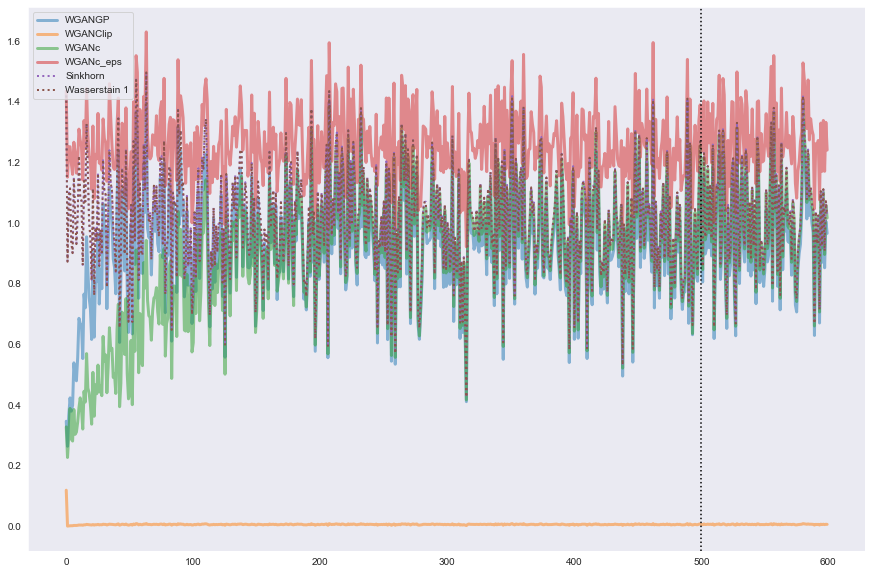

In [35]:
utils.print_loss(losses, config["train_epoches"])

We see that the *Weight Clip* is not at all capable of reaching the true Wasserstain distance of the batch but for *GP* and both *transform* we observe a good convergence to the Wasserstain distance.

### Multinomial Dataset

This time we do the same experiments but with more difficult distributions. 
Here we set the dimension for our multinomial to 3.

In [36]:
size = config["size"]
mean1 = torch.arange(size, dtype=torch.float32)
cov1_tril = torch.tril(torch.rand((size, size)))
cov1 = cov1_tril@cov1_tril.T

mean2 = torch.arange(size, size*2, dtype=torch.float32)
cov2_tril = torch.tril(torch.rand((size, size)))
cov2 = cov2_tril@cov2_tril.T

dist1 = MultivariateNormal(mean1, cov1)
dist2 = MultivariateNormal(mean2, cov2)

train_epoches = 1000
val_epoches = 100

### Models

We need to reinitialise the models.

In [37]:
### WGANClip
# Network
netD_Clip = utils.get_MLP(size, 128, config["device"])

# Clipper and optimizer
clipper = WeightClipper(config["c_Clip"])
optimD_Clip = RMSprop(netD_Clip.parameters(), lr=config["lr_Clip"])

### WGANGP
# Network
netD_GP = utils.get_MLP(size, 128, config["device"])

# Optimizer
optimD_GP = Adam(netD_GP.parameters(), 
                 lr=config["lr_GP"], 
                 betas=config["betas_GP"])

### WGANc
# Network
netD_C = utils.get_MLP(size, 128, config["device"])

# Optimizer
optimD_C = RMSprop(netD_C.parameters(), lr=config["lr_c"])

### WGANc_eps
# Network
netD_C_eps = utils.get_MLP(size, 128, config["device"])

# Optimizer
eps = 1
optimD_C_eps = RMSprop(netD_C_eps.parameters(), lr=config["lr_c_eps"])

### Experiments

In [38]:
losses = {
    "WGANGP": [],
    "WGANClip": [],
    "WGANc": [],
    "WGANc_eps": [],
    "Sinkhorn": [],
}

for epoch in (pbar := tqdm(range(config["train_epoches"]))):
    X_1_batch = dist1.rsample(config["batch_size"]).to(config['device'])
    X_2_batch = dist2.rsample(config["batch_size"]).to(config['device'])

    ### WGANClip
    optimD_Clip.zero_grad()
    e_X_1 = netD_Clip(X_1_batch).mean()
    e_X_2 = netD_Clip(X_2_batch).mean()
    netD_loss = e_X_1 - e_X_2 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()
    
    optimD_Clip.step()
    
    netD_Clip.apply(clipper)
    losses["WGANClip"].append(netD_loss.item())
    
    ### WGANGP
    optimD_GP.zero_grad()
    e_X_1 = netD_GP(X_1_batch).mean()
    e_X_2 = netD_GP(X_2_batch).mean()

    netD_loss = e_X_1 - e_X_2 

    mix_alpha = torch.rand((len(X_1_batch), 1), device=config['device'])
    mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
    mixed.requires_grad_(True)
    mixed_preds = netD_GP(mixed).sum()
    grads = torch.autograd.grad(
        outputs=mixed_preds,
        inputs=mixed,
        create_graph=True,
        retain_graph=True,
    )[0]
    grads = grads.view(len(X_1_batch), -1)
    grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

    netD_total_loss = -(netD_loss - config['w_gp'] * grad_loss)
    netD_total_loss.backward()
    optimD_GP.step()

    losses["WGANGP"].append(netD_loss.item())

    ### WGAN (c)
    optimD_C.zero_grad()
    phi_X_1 = netD_C(X_1_batch)
    phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

    netD_loss = phi_X_1.mean() + phi_X_2.mean() 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()

    optimD_C.step()
    losses["WGANc"].append(netD_loss.item())
    
    ### WGAN (c, eps)
    optimD_C_eps.zero_grad()
    phi_X_1 = netD_C_eps(X_1_batch)
    phi_X_2 = -config["(c,eps)_eps"]*torch.log(
                            torch.mean(
                                torch.exp(
                                    -(1/config["(c,eps)_eps"])*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                ), 
                            1, keepdims=True)
                        )

    netD_loss = phi_X_1.mean() + phi_X_2.mean() 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()

    optimD_C_eps.step()
    losses["WGANc_eps"].append(netD_loss.item())
    
    
    ### Sinhkorn
    with torch.no_grad():
        C = torch.cdist(X_1_batch, X_2_batch, p=2)
        a = torch.ones((X_1_batch.shape[0],), device=config["device"])/X_1_batch.shape[0]
        b = torch.ones((X_2_batch.shape[0],), device=config["device"])/X_2_batch.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        losses["Sinkhorn"].append((P*C).sum().item())
        
    
for epoch in (pbar := tqdm(range(config["val_epoches"]))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(config["batch_size"]).to(config['device'])
        X_2_batch = dist2.rsample(config["batch_size"]).to(config['device'])

        ### WGAN Clip
        e_X_1 = netD_Clip(X_1_batch).mean()
        e_X_2 = netD_Clip(X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        losses["WGANClip"].append(netD_loss.item())

        ### WGANGP
        e_X_1 = netD_GP(X_1_batch).mean()
        e_X_2 = netD_GP(X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 
        losses["WGANGP"].append(netD_loss.item())


        ### WGAN (c)
        phi_X_1 = netD_C(X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 
        losses["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        phi_X_1 = netD_C_eps(X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                         -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        losses["WGANc_eps"].append(netD_loss.item())

        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=2)
            a = torch.ones((X_1_batch.shape[0],), device=config["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=config["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses["Sinkhorn"].append((P*C).sum().item())

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

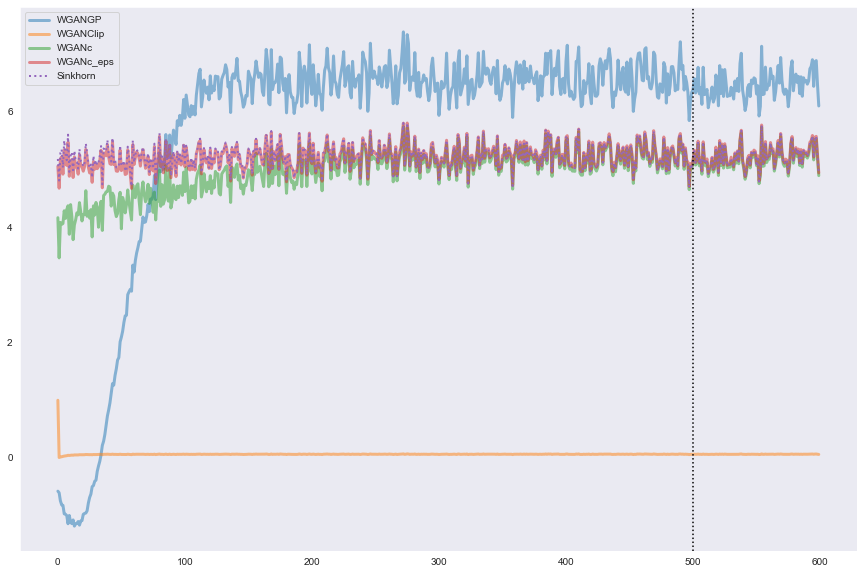

In [39]:
utils.print_loss(losses, config["train_epoches"])

We see that when the distributions become more complex only the *transform* schemes seems to converge to the true distance.